In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
# function for image thresholding
def imThreshold(img, threshold, maxVal):
    assert len(img.shape) == 2 # input image has to be gray
    
    height, width = img.shape   # getting image dimension
    bi_img = np.zeros((height, width), dtype=np.uint8)      # creating a matrix of image size filled with zeros
    for x in range(height):
        for y in range(width):
            if img.item(x, y) > threshold:
                bi_img.itemset((x, y), maxVal)              # If pixel intensity > threshold, set to 255, otherwise 0
                
    return bi_img

# **Heart Chamber thresholding**

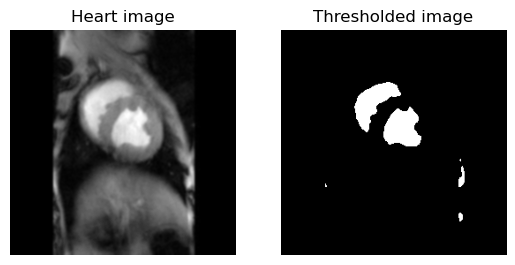

In [209]:
# read image in BGR format
heart = cv2.imread('./heart.jpg')

# convert a color image to gray
img_gray = cv2.cvtColor(heart, cv2.COLOR_BGR2GRAY)
img_gray = cv2.GaussianBlur(img_gray, (5,5), 0)

# image thresholding using global tresholder
img_bi = imThreshold(img_gray, 165, 255)

# plt.figure(figsize=(25, 20))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Heart image')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_bi, 'gray')
plt.title('Thresholded image')
plt.axis("off")

plt.show()

# **Brain Tumor Thresholding**

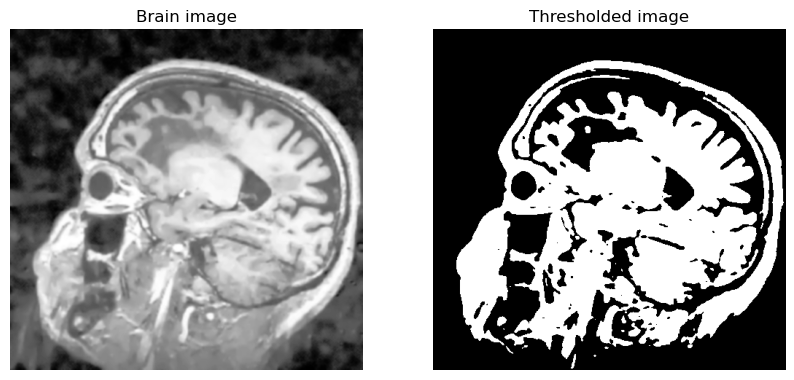

In [77]:
# read image in BGR format
brain = cv2.imread('./brain.tech.jpg')
brain = brain[80:-160, 195:-200]

# convert a color image to gray
img_gray = cv2.cvtColor(brain, cv2.COLOR_BGR2GRAY)
img_gray = cv2.GaussianBlur(img_gray, (5,5), 0)

# image thresholding using global tresholder
img_bi = imThreshold(img_gray, 155, 255)
# img_bi = cv2.threshold(img_gray, 150, 255, 'THRESH_BINARY_INV')

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Brain image')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_bi, 'gray')
plt.title('Thresholded image')
plt.axis("off")
# plt.tight_layout()
plt.show()

# **Watershed Segmentation**

The watershed segmentation is a classical image segmentation method that is often used to segment objects in an image based on their boundaries.

The basic idea behind the watershed segmentation is to view the image as a topographic surface where the intensity values represent the height of the surface. The goal is to identify the "basins" in this surface that correspond to the different objects in the image.

The watershed segmentation method can be broken down into the following steps:

1. First we compute the gradient magnitude of the image, which represents the magnitude of the intensity changes at each pixel location:

G(x, y) = ||∇I(x, y)||

where I(x, y) is the intensity of the image at pixel (x, y), and ∇I(x, y) is the gradient of the image at that location.

2. Then we threshold the gradient image to obtain a binary image that highlights the boundaries between different regions:

B(x, y) = {1 if G(x, y) > T, 0 otherwise}

where T is the threshold value.

3. Then we compute the distance transform of the binary image, which assigns a distance value to each pixel based on its distance to the nearest boundary:

D(x, y) = min{||p-q||} for all q such that B(q) = 1

where p = (x, y) is the current pixel location.

4. Then we compute the watershed transform of the distance image, which assigns a label to each pixel based on its "catchment basin":

W(x, y) = {i if L(p) = i for all p such that D(p) <= D(x, y)}

where L(p) is the label of the pixel p in the binary image.

In this way, the watershed segmentation method assigns each pixel in the image to a particular object label based on the basin in which it falls. The resulting segmented image consists of different objects separated by their boundaries.

Note that the watershed segmentation method can suffer from over-segmentation or under-segmentation, especially in regions with flat or low-contrast regions. Therefore, additional post-processing steps such as merging, splitting, or using prior knowledge can be used to refine the segmentation results.

# **Watershed Implementation**

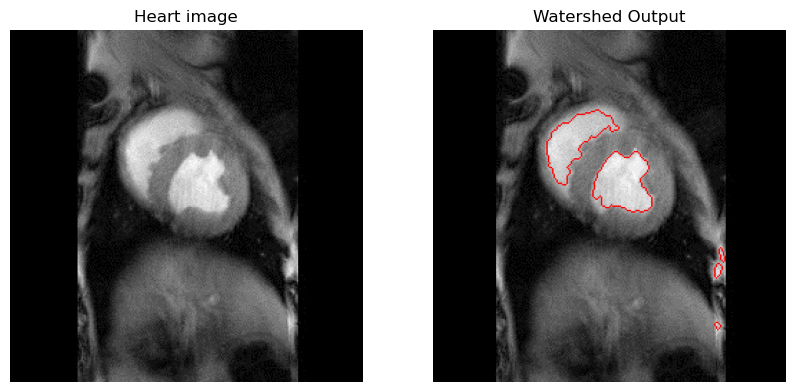

In [78]:
# Read image
img = cv2.imread('./heart.jpg')
border = 5
# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to obtain a binary image
ret, thresh = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)

# Perform morphological opening to remove noise and small objects
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

# Compute the distance transform of the binary image
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.07*dist_transform.max(), 255, cv2.THRESH_BINARY)

# Compute the watershed transform of the distance image
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(opening, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown==255] = 0
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]
img = img[border:-border, border:-border]

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(gray, 'gray')
plt.title('Heart image')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img, 'gray')
plt.title('Watershed Output')
plt.axis('off')

plt.show()



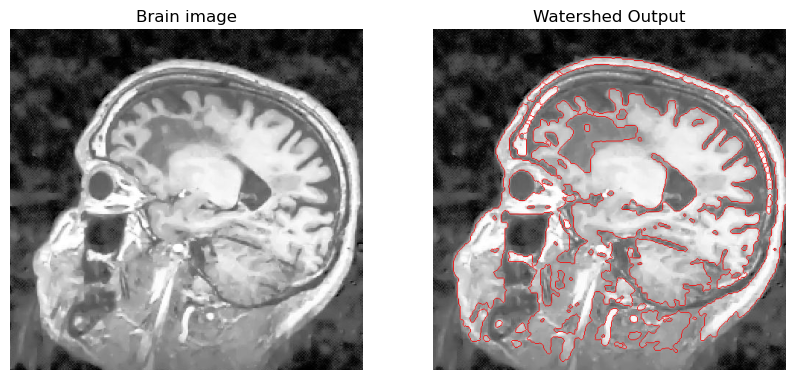

In [79]:
# Read image
img = cv2.imread('./brain.tech.jpg')
img = img[80:-160, 195:-200]
border = 5

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to obtain a binary image
ret, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

# Perform morphological opening to remove noise and small objects
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

# Compute the distance transform of the binary image
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(), 255, cv2.THRESH_BINARY)


# Compute the watershed transform of the distance image
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(opening, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1

markers[unknown==255] = 0
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]
img = img[border:-border, border:-border]

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(gray, 'gray')
plt.title('Brain image')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img, 'gray')
plt.title('Watershed Output')
plt.axis('off')

plt.show()


# **LoG operation for Edge Detection**

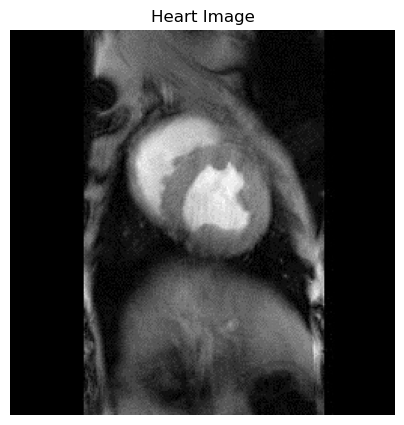

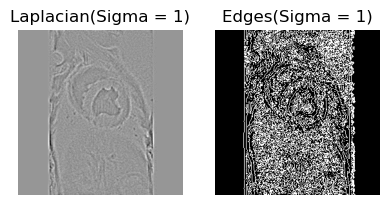

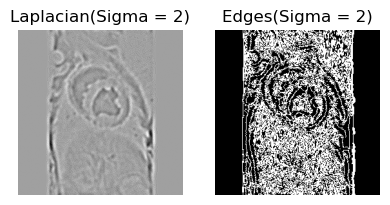

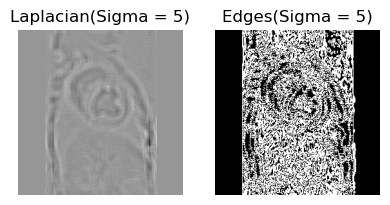

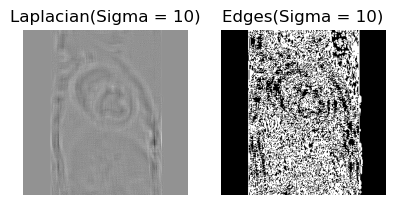

In [249]:
def zero_cross_detection(image):
    edges = np.zeros_like(image)
    edges[np.where(np.diff(np.sign(image)))] = 255
    return edges

# Load the image
img = cv2.imread('./heart.jpg', 0)

plt.figure(figsize=(5,5))
plt.imshow(img, 'gray')
plt.axis('off')
plt.title('Heart Image')
plt.show()

# Apply the LoG operator to the image
sigmas = [1, 2, 5, 10]
i = 0
for sigma in sigmas:
    i = i+1
    img_gaussian = cv2.GaussianBlur(img, (11, 11), sigma)
    img_log = cv2.Laplacian(img_gaussian, cv2.CV_64F)

    img_edges = zero_cross_detection(img_log)

    # Display the original image and the edges
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 8, i)
    plt.imshow(img_log, 'gray')
    plt.title(f'Laplacian(Sigma = {sigma})')
    plt.axis('off')
    plt.subplot(1, 8, i+1)
    plt.imshow(img_edges, 'gray')
    plt.title(f'Edges(Sigma = {sigma})')
    plt.axis('off')

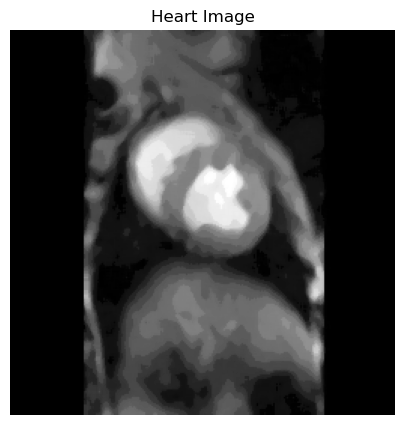

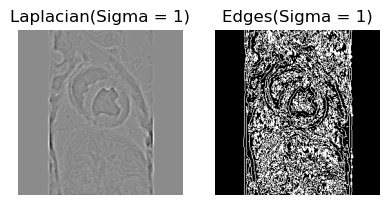

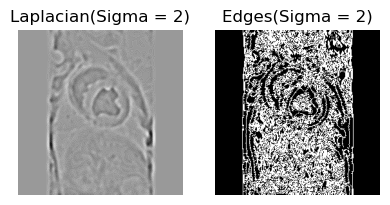

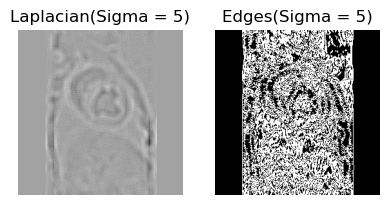

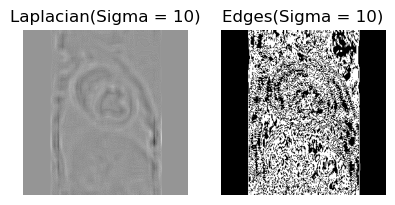

In [3]:
def zero_cross_detection(image):
    edges = np.zeros_like(image)
    edges[np.where(np.diff(np.sign(image)))] = 255
    return edges

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('./heart.jpg', 0)
img = cv2.medianBlur(img, 5)

plt.figure(figsize=(5,5))
plt.imshow(img, 'gray')
plt.axis('off')
plt.title('Heart Image')
plt.show()

# Apply the LoG operator to the image
sigmas = [1, 2, 5, 10]
i = 0
for sigma in sigmas:
    i = i+1
    img_gaussian = cv2.GaussianBlur(img, (11, 11), sigma)
    img_log = cv2.Laplacian(img_gaussian, cv2.CV_64F)

    img_edges = zero_cross_detection(img_log)

    # Display the original image and the edges
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 8, i)
    plt.imshow(img_log, 'gray')
    plt.title(f'Laplacian(Sigma = {sigma})')
    plt.axis('off')
    plt.subplot(1, 8, i+1)
    plt.imshow(img_edges, 'gray')
    plt.title(f'Edges(Sigma = {sigma})')
    plt.axis('off')

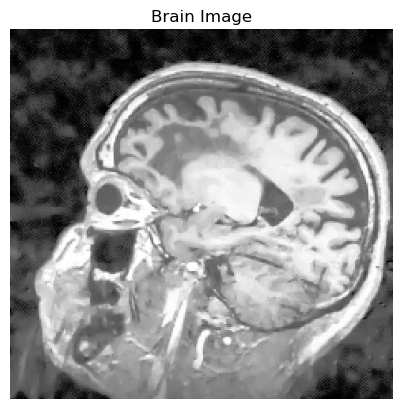

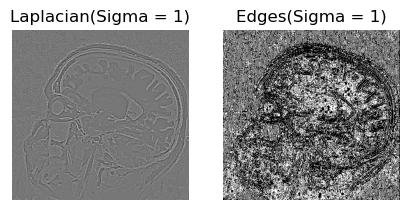

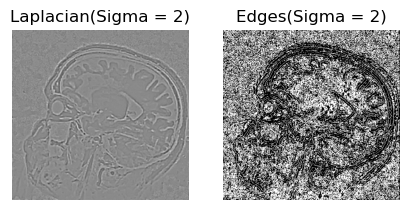

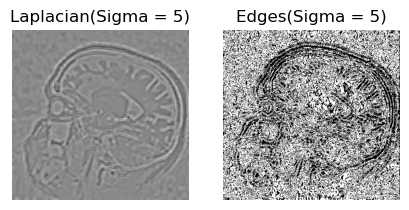

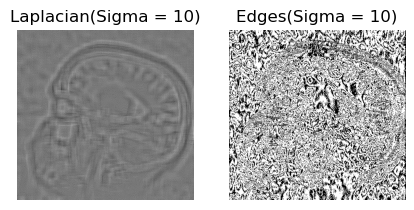

In [250]:
# Load the image
img = cv2.imread('./brain.tech.jpg', 0)
img = img[80:-160, 195:-200]
# Convert image to grayscale
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.GaussianBlur(img, 5, )

# Define the LoG kernel size and sigma value
# kernel_size = 11
sigmas = [1, 2, 5, 10]

i = 0
plt.imshow(img, 'gray')
plt.title('Brain Image')
plt.axis('off')
plt.show()

# Apply the LoG operator to the image
for sigma in sigmas:
    i = i+1
    kernel_size = int(2*sigma)+1
    img_gaussian = cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)
    img_log = cv2.Laplacian(img_gaussian, cv2.CV_64F)

    img_edges = zero_cross_detection(img_log)

    # Display the original image and the edges
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_log, 'gray')
    plt.title(f'Laplacian(Sigma = {sigma})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_edges, 'gray')
    plt.title(f'Edges(Sigma = {sigma})')
    plt.axis('off')

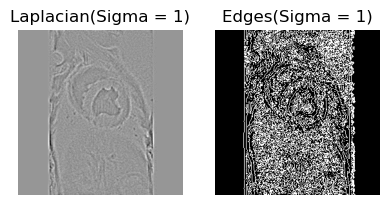

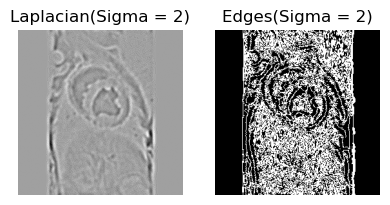

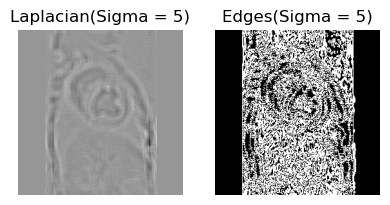

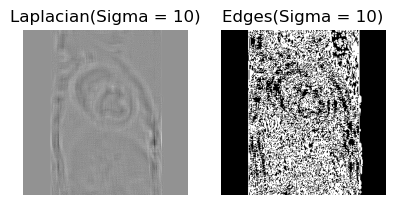

In [245]:
def zero_cross_detection(image):
    edges = np.zeros_like(image)
    edges[np.where(np.diff(np.sign(image)))] = 255
    return edges

# Load the image
img = cv2.imread('./heart.jpg', 0)

# Apply the LoG operator to the image
sigmas = [1, 2, 5, 10]
i = 0
for sigma in sigmas:
    i = i+1
    img_gaussian = cv2.GaussianBlur(img, (11, 11), sigma)
    img_log = cv2.Laplacian(img_gaussian, cv2.CV_64F)

    img_edges = zero_cross_detection(img_log)

    # Display the original image and the edges
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 8, i)
    plt.imshow(img_log, 'gray')
    plt.title(f'Laplacian(Sigma = {sigma})')
    plt.axis('off')
    plt.subplot(1, 8, i+1)
    plt.imshow(img_edges, 'gray')
    plt.title(f'Edges(Sigma = {sigma})')
    plt.axis('off')

# **Histogram Equalization**

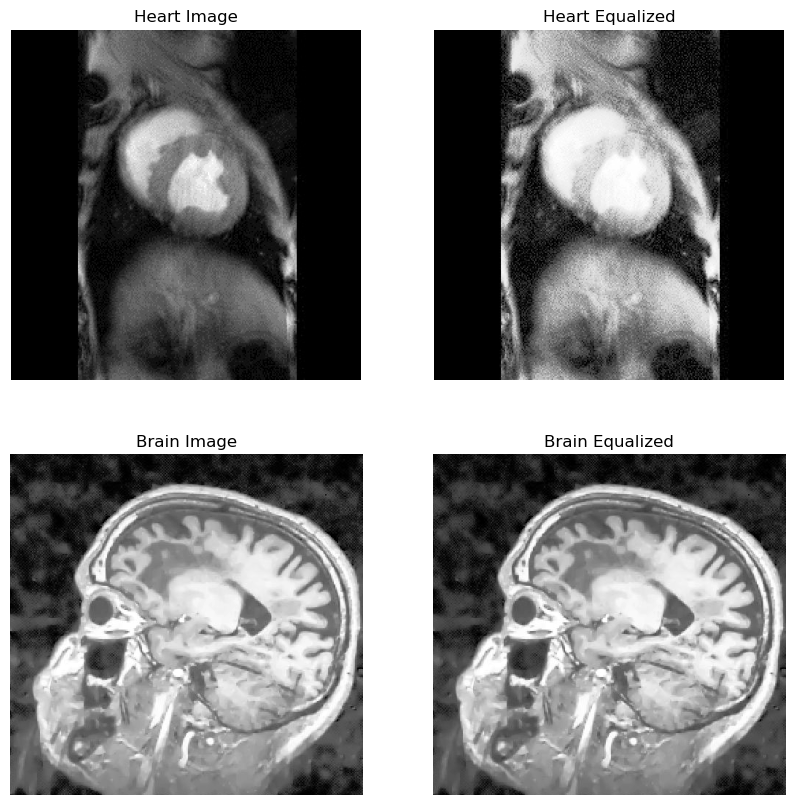

In [232]:
def histogram_equalization(img):
    hist, _ = np.histogram(img.flatten(), 256,[0,255])     # get the histogram
    H, W = img.shape
    PDF = hist / np.sum(hist)             # generate the probability distribution function
    CDF = PDF.cumsum()                    # get the cumulative distribution function

    # transforming the V channel
    CDF_transform = (CDF - CDF.min()) / (CDF.max() - CDF.min()) * 255
    CDF_transform = CDF_transform.astype('uint8')
    img_transform = CDF_transform[np.asarray(img).flatten()]
    img_transform = img_transform.reshape(H, W)

    return img_transform


heart = cv2.imread('./heart.jpg')
brain = cv2.imread('./brain.tech.jpg')
heart = cv2.cvtColor(heart, cv2.COLOR_BGR2GRAY)
brain = cv2.cvtColor(brain, cv2.COLOR_BGR2GRAY)
brain = brain[80:-160, 195:-200]

# equ = cv2.equalizeHist(heart)
# equ1 = cv2.equalizeHist(brain)
equ = histogram_equalization(heart)
equ1 = histogram_equalization(brain)


plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.imshow(heart, 'gray')
plt.title('Heart Image')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(equ, 'gray')
plt.title('Heart Equalized')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(brain, 'gray')
plt.title('Brain Image')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(equ1, 'gray')
plt.title('Brain Equalized')
plt.axis('off')

plt.show()


# **Image Sharpening**

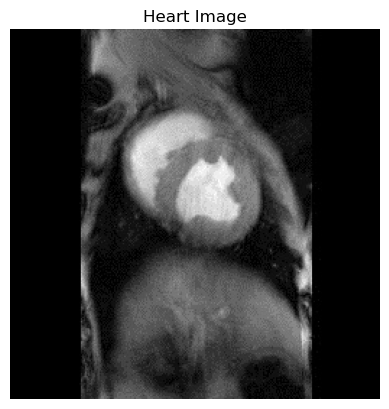

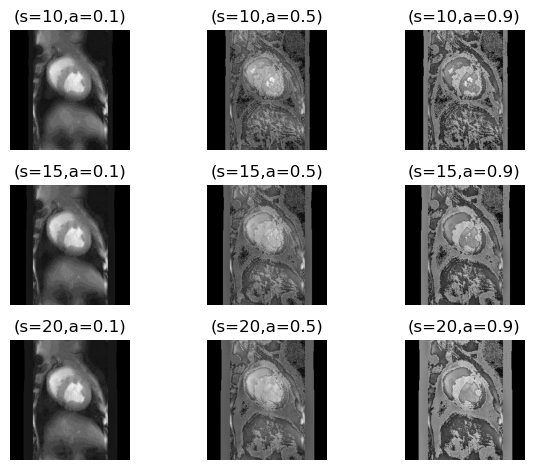

In [234]:
def genGaussianKernel(width, sigma):    
    kernel = np.zeros([width,width])            # creating a blank matrix of kernel size 
    for x in range(width):
      for y in range(width):
          kernel[x,y] = 1/(2*np.pi*sigma**2)*np.exp(-((x-width//2)**2+(y-width//2)**2)/(2*sigma**2))     # creating the kernel F = 1/(2*pi*sigma^2) exp(-(x^2+y^2)/(2*sigma^2))
    kernel_2d = kernel/np.sum(kernel)       # Normalizing the kernel           
    return kernel_2d

sigmas = [10, 15, 20]
alphas = [0.1, 0.5, 0.9]

Heart = cv2.imread('./heart.jpg', 0)

plt.imshow(Heart, 'gray')
plt.axis('off')
plt.title('Heart Image')
plt.show()
i = 0
for sigma in sigmas:
   for alpha in alphas:
        i = i+1
        H = genGaussianKernel(2*sigma+1, sigma)
        out = Heart + alpha * (Heart - cv2.filter2D(Heart, -1, H ))
        # plt.figure(figsize=(5,5))

        plt.subplot(3,3,i)
        plt.imshow(out, 'gray')
        plt.title(f'(s={sigma},a={alpha})')
        plt.axis('off')

plt.tight_layout()
